In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as cpio
import os
import time

# Define the folder that contains all data files
# Each data file contains the variables:
#    s: The spectrogram [size = 513 x time_steps]
#    f: Frequencies [size = 513]
#    t: Time steps
#    labels: The tagging data [size = time_steps]
data_directory = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/mat'
# This folder must also contain a matlab file 'file_list.mat' with cell array 'keys' that holds the data file names
data_list = cpio.loadmat(data_directory + '/file_list.mat')
number_of_files = len(data_list['keys'][0])
# The folder for saving training checkpoints
training_records_dir = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records'

In [2]:
# Parameters
input_vec_size = lstm_size = 513
batch_size = 11
n_lstm_layers = 2
n_syllables = 28 #including zero
learning_rate = 0.001
n_max_iter = 10001

In [3]:
# The inference graph
def label_inference_graph(spectrogram, num_hidden, num_layers, seq_length):
    # First the dynamic bi-directional, multi-layered LSTM
    with tf.name_scope('biRNN'): 
        with tf.variable_scope('fwd'):
            lstm_f1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_f2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_f3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_f = tf.contrib.rnn.MultiRNNCell([lstm_f1,lstm_f2], state_is_tuple=True)
        with tf.variable_scope('bck'):
            lstm_b1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_b2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_b3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_b = tf.contrib.rnn.MultiRNNCell([lstm_b1,lstm_b2], state_is_tuple=True)
        outputs, _states = tf.nn.bidirectional_dynamic_rnn(cells_f,cells_b, spectrogram, time_major=False, dtype=tf.float32,sequence_length=seq_length)
    # Second, projection on the number of syllables creates logits 
    with tf.name_scope('Projection'):
        W_f = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        W_b = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        bias = tf.Variable(tf.random_normal([n_syllables]))
    expr1 = tf.unstack(outputs[0],axis=0,num=batch_size)
    expr2 = tf.unstack(outputs[1],axis=0,num=batch_size)
    #logits = [tf.matmul(outputs[0][:,a,:],W_f) + bias + tf.matmul(outputs[1][:,a,:],W_b) for a in range(seq_length[0])]
    logits = tf.concat([tf.matmul(ex1,W_f) + bias + tf.matmul(ex2,W_b) for ex1,ex2 in zip(expr1,expr2)],0)
    return logits,outputs

In [4]:
# The training graph. Calculate cross entropy and loss function
def training_graph(logits, lbls, rate, lng):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.concat(tf.unstack(lbls,axis=0,num=batch_size),0), name='xentropy') 
    cost = tf.reduce_mean(xentropy, name='cost')
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op, cost

In [5]:
# Construct the full graph and add saver
full_graph = tf.Graph()
with full_graph.as_default():
    # Generate placeholders for the spectrograms and labels.
    X = tf.placeholder("float", [None,None,input_vec_size], name = "Xdata") # holds spectrograms
    Y = tf.placeholder("int32",[None,None],name = "Ylabels") # holds labels
    lng = tf.placeholder("int32",name = "nSteps") # holds the sequence length
                                    
    tf.add_to_collection("specs", X)  # Remember this Op.
    tf.add_to_collection("labels", Y)  # Remember this Op.
    tf.add_to_collection("lng", lng)  # Remember this Op.

    # Build a Graph that computes predictions from the inference model.
    logits,outputs = label_inference_graph(X, lstm_size, n_lstm_layers, lng)
    tf.add_to_collection("logits", logits)  # Remember this Op.

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op, cost = training_graph(logits, Y, learning_rate, lng) 
    
    # Add the variable initializer Op.
    init = tf.global_variables_initializer() #initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver(max_to_keep = 10)

In [6]:
# Train and save checkpoint at the end of each file.
with tf.Session(graph=full_graph,config = tf.ConfigProto(
    intra_op_parallelism_threads = batch_size)) as sess:
    # Run the Op to initialize the variables.
    sess.run(init)
    # Start the training loop.
    costs = []
    step = 1
    # Go over all training files
    file_num = 0
    fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
    data = cpio.loadmat(data_directory + '/' + fname)
    data1 = np.transpose(data['s'])
    intY = data['labels'][0]
    for file_num in range(number_of_files-1):
        # load current training file
        fname = data_list['keys'][0][file_num+1][0][0:-3]+'mat'
        bdata = cpio.loadmat(data_directory + '/' + fname)
        bdata1 = np.transpose(bdata['s'])
        bintY = bdata['labels'][0]
        data1 = np.concatenate((data1,bdata1),axis = 0)
        intY = np.concatenate((intY,bintY),axis = 0)
    temp_n = len(intY)/batch_size
    data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
    intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
    iter_order = np.random.permutation(data1.shape[1]-370)
    if (len(iter_order) > n_max_iter):
        iter_order = iter_order[0:n_max_iter]
    print data1.shape, len(iter_order)
    for iternum in iter_order:
        d = {X: data1[:,iternum:iternum+100,:] ,Y: intY[:,iternum:iternum+100] ,lng:[100]*batch_size}
        _cost,_ = sess.run((cost,train_op),feed_dict = d)
        costs.append(_cost)
        print([step,iternum,_cost])
        step = step + 1
            
        if (step % 100 == 0):    
            checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=step)
            print np.mean(costs[-10:-1])
    checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)
        

(11, 5696, 513) 5326
[1, 1549, 3.522841]
[2, 1161, 10.394522]
[3, 2272, 6.3615761]
[4, 3297, 4.5110345]
[5, 512, 2.5649054]
[6, 24, 1.9465641]
[7, 228, 1.4647985]
[8, 5027, 1.7639827]
[9, 3035, 1.5720155]
[10, 3611, 2.0218196]
[11, 1078, 2.6903152]
[12, 322, 0.57996023]
[13, 1849, 3.1702878]
[14, 1703, 1.5848497]
[15, 4287, 1.6048172]
[16, 2232, 0.85018486]
[17, 2624, 1.0006489]
[18, 4497, 1.2376844]
[19, 3889, 0.77438587]
[20, 260, 0.50228339]
[21, 1911, 1.7366465]
[22, 1920, 0.94566172]
[23, 3179, 1.1947087]
[24, 4613, 0.5142805]
[25, 3403, 1.2694243]
[26, 869, 1.6483098]
[27, 2178, 0.90249997]
[28, 4406, 0.89455253]
[29, 4997, 0.80386555]
[30, 3679, 0.77108544]
[31, 567, 0.72954512]
[32, 20, 0.85201365]
[33, 4013, 0.50352228]
[34, 3322, 0.33891496]
[35, 423, 0.31181702]
[36, 3352, 0.40841398]
[37, 5142, 0.34398094]
[38, 1298, 1.6009012]
[39, 1358, 0.9736076]
[40, 290, 0.29332444]
[41, 3430, 0.28740951]
[42, 1175, 1.2724355]
[43, 3846, 0.27503097]
[44, 1235, 0.44296291]
[45, 1396, 0.

[351, 1660, 0.19136101]
[352, 2136, 0.16525149]
[353, 1928, 0.43840444]
[354, 2693, 0.16846652]
[355, 4468, 0.1849549]
[356, 2770, 0.092832603]
[357, 3821, 0.27582148]
[358, 285, 0.18979052]
[359, 1676, 0.24183983]
[360, 5194, 0.19718611]
[361, 5251, 0.11458801]
[362, 2913, 0.11477225]
[363, 1009, 0.1245029]
[364, 4054, 0.14637813]
[365, 3812, 0.24726507]
[366, 3313, 0.30471152]
[367, 1045, 0.13448851]
[368, 4171, 0.18068711]
[369, 4475, 0.19875973]
[370, 2342, 0.13255958]
[371, 53, 0.32769659]
[372, 115, 0.27248967]
[373, 3516, 0.1434291]
[374, 328, 0.17415355]
[375, 1482, 0.23491643]
[376, 3356, 0.092202395]
[377, 256, 0.12952839]
[378, 10, 0.13144882]
[379, 225, 0.081872188]
[380, 183, 0.080840744]
[381, 3526, 0.13406588]
[382, 1145, 0.60802019]
[383, 1328, 0.20754994]
[384, 4279, 0.18685526]
[385, 4205, 0.11738406]
[386, 2931, 0.11699755]
[387, 1068, 0.16847757]
[388, 4652, 0.10171735]
[389, 4875, 0.21286072]
[390, 5068, 0.12090765]
[391, 4750, 0.33374611]
[392, 4556, 0.72976816]
[

[693, 184, 0.10453036]
[694, 1189, 0.28190285]
[695, 4179, 0.080300748]
[696, 79, 0.16403648]
[697, 3659, 0.20469946]
[698, 1100, 0.37678733]
[699, 218, 0.065508038]
0.192611
[700, 1088, 0.26440713]
[701, 3496, 0.1433693]
[702, 4713, 0.12340099]
[703, 940, 0.099185795]
[704, 901, 0.16567299]
[705, 457, 0.20945598]
[706, 4939, 0.2101921]
[707, 902, 0.097486727]
[708, 3627, 0.12761894]
[709, 4636, 0.067096204]
[710, 1399, 0.10288709]
[711, 3791, 0.20463899]
[712, 640, 0.50045788]
[713, 5086, 0.10542688]
[714, 2146, 0.18294623]
[715, 404, 0.17611372]
[716, 3517, 0.10834847]
[717, 2337, 0.082271449]
[718, 4547, 0.38578495]
[719, 3640, 0.089481093]
[720, 2239, 0.13030565]
[721, 3187, 0.20550866]
[722, 1605, 0.15818118]
[723, 4850, 0.11111392]
[724, 4536, 0.11363757]
[725, 2114, 0.088494033]
[726, 4098, 0.13112807]
[727, 1193, 0.29134765]
[728, 2253, 0.077272452]
[729, 4397, 0.090542488]
[730, 2030, 0.10967132]
[731, 5110, 0.069418408]
[732, 3760, 0.20910591]
[733, 978, 0.1068717]
[734, 622,

[1031, 780, 0.057250813]
[1032, 4174, 0.097346351]
[1033, 2405, 0.089647382]
[1034, 3213, 0.11226639]
[1035, 270, 0.077480957]
[1036, 2750, 0.18656702]
[1037, 2652, 0.11372554]
[1038, 1881, 0.27434149]
[1039, 1194, 0.56641394]
[1040, 1988, 0.23057586]
[1041, 5018, 0.093742497]
[1042, 2120, 0.10802884]
[1043, 2676, 0.067690939]
[1044, 3899, 0.20188399]
[1045, 4586, 0.33057112]
[1046, 3344, 0.41639367]
[1047, 4782, 0.29589823]
[1048, 3912, 0.12577333]
[1049, 4804, 0.30881405]
[1050, 3737, 0.072096713]
[1051, 1386, 0.11896018]
[1052, 3788, 0.1501134]
[1053, 72, 0.29432562]
[1054, 886, 0.21721904]
[1055, 5283, 0.23823415]
[1056, 4793, 0.14385092]
[1057, 1854, 0.20487793]
[1058, 66, 0.11324345]
[1059, 4605, 0.10252662]
[1060, 4836, 0.13301277]
[1061, 4243, 0.11382286]
[1062, 3239, 0.22283773]
[1063, 166, 0.14355144]
[1064, 3008, 0.092919424]
[1065, 3357, 0.13654137]
[1066, 4906, 0.14322792]
[1067, 2782, 0.10951939]
[1068, 1203, 0.39651737]
[1069, 3084, 0.086285822]
[1070, 4794, 0.11473709]


[1359, 4129, 0.08704672]
[1360, 3662, 0.12550823]
[1361, 969, 0.14119573]
[1362, 1251, 0.21022835]
[1363, 4866, 0.30438277]
[1364, 1228, 0.23972246]
[1365, 515, 0.0506186]
[1366, 5025, 0.10229206]
[1367, 196, 0.15919223]
[1368, 3600, 0.23097816]
[1369, 3004, 0.079354845]
[1370, 3232, 0.076743357]
[1371, 714, 0.094112478]
[1372, 965, 0.062622115]
[1373, 1969, 0.13673511]
[1374, 2096, 0.076177716]
[1375, 620, 0.090526588]
[1376, 1334, 0.28908569]
[1377, 1040, 0.083074771]
[1378, 3092, 0.086686306]
[1379, 3563, 0.058057945]
[1380, 1910, 0.20474951]
[1381, 373, 0.097541161]
[1382, 4414, 0.089756109]
[1383, 2141, 0.11103073]
[1384, 4769, 0.12207081]
[1385, 3948, 0.087237865]
[1386, 2532, 0.033513296]
[1387, 3867, 0.074777521]
[1388, 4432, 0.083285987]
[1389, 377, 0.04000815]
[1390, 1554, 0.14713821]
[1391, 854, 0.12076455]
[1392, 5268, 0.062277965]
[1393, 1708, 0.10529977]
[1394, 5040, 0.068872012]
[1395, 4275, 0.10901602]
[1396, 5048, 0.074005827]
[1397, 447, 0.080495052]
[1398, 82, 0.1985

[1681, 1787, 0.16312863]
[1682, 4718, 0.048153996]
[1683, 543, 0.091874421]
[1684, 380, 0.034179647]
[1685, 771, 0.038790837]
[1686, 1441, 0.077804014]
[1687, 2059, 0.096717931]
[1688, 1831, 0.21707425]
[1689, 3633, 0.089735456]
[1690, 1887, 0.11957597]
[1691, 3118, 0.10121871]
[1692, 4376, 0.076725759]
[1693, 4125, 0.15765832]
[1694, 37, 0.22788724]
[1695, 405, 0.024614189]
[1696, 1967, 0.15773831]
[1697, 980, 0.11464025]
[1698, 1093, 0.22355835]
[1699, 4490, 0.21444754]
0.133735
[1700, 2241, 0.074369244]
[1701, 4805, 0.09350872]
[1702, 2403, 0.14029923]
[1703, 224, 0.052404702]
[1704, 4932, 0.094477862]
[1705, 3257, 0.12421018]
[1706, 3106, 0.14323972]
[1707, 2075, 0.096880175]
[1708, 3831, 0.13388565]
[1709, 772, 0.037071556]
[1710, 385, 0.03744518]
[1711, 4541, 0.18094814]
[1712, 1904, 0.1439431]
[1713, 4076, 0.070247412]
[1714, 2587, 0.041317109]
[1715, 2233, 0.074253529]
[1716, 3163, 0.086545646]
[1717, 3489, 0.099981561]
[1718, 3929, 0.067410111]
[1719, 3146, 0.056044053]
[1720,

[2002, 4145, 0.10683539]
[2003, 733, 0.037701596]
[2004, 4760, 0.10317892]
[2005, 4723, 0.11142791]
[2006, 2650, 0.05597103]
[2007, 647, 0.032105144]
[2008, 272, 0.04917486]
[2009, 2586, 0.033655494]
[2010, 2095, 0.086024962]
[2011, 4090, 0.083707578]
[2012, 3690, 0.063022546]
[2013, 1174, 0.16773102]
[2014, 2208, 0.064540602]
[2015, 4763, 0.051624507]
[2016, 1034, 0.056099318]
[2017, 1037, 0.054092228]
[2018, 1374, 0.24758881]
[2019, 738, 0.025079967]
[2020, 2266, 0.06558945]
[2021, 4215, 0.11409818]
[2022, 2560, 0.040073719]
[2023, 706, 0.052538443]
[2024, 1601, 0.12295825]
[2025, 2201, 0.090442479]
[2026, 2323, 0.07298433]
[2027, 3569, 0.071915232]
[2028, 4623, 0.076637588]
[2029, 3454, 0.10851015]
[2030, 716, 0.033875525]
[2031, 479, 0.059872422]
[2032, 2018, 0.29366145]
[2033, 402, 0.04669635]
[2034, 215, 0.029622747]
[2035, 5209, 0.066402584]
[2036, 3874, 0.06022701]
[2037, 2905, 0.075475231]
[2038, 4799, 0.1827452]
[2039, 2718, 0.039882448]
[2040, 3249, 0.079437874]
[2041, 4753,

[2323, 4109, 0.051955838]
[2324, 1563, 0.090109542]
[2325, 2543, 0.028382026]
[2326, 5301, 0.058006413]
[2327, 254, 0.045372292]
[2328, 4913, 0.075309165]
[2329, 1628, 0.079389296]
[2330, 4198, 0.072632909]
[2331, 5265, 0.049085949]
[2332, 3507, 0.12287837]
[2333, 1980, 0.079228267]
[2334, 3920, 0.063471422]
[2335, 990, 0.043751575]
[2336, 3251, 0.064412393]
[2337, 5030, 0.078523353]
[2338, 5175, 0.057943068]
[2339, 323, 0.046756774]
[2340, 4995, 0.069563493]
[2341, 3168, 0.12120016]
[2342, 2938, 0.051065788]
[2343, 4034, 0.04087007]
[2344, 2121, 0.086163037]
[2345, 4400, 0.07984148]
[2346, 3607, 0.10499068]
[2347, 1106, 0.071408153]
[2348, 3596, 0.052453008]
[2349, 1450, 0.087216794]
[2350, 510, 0.045622926]
[2351, 2431, 0.072294496]
[2352, 5069, 0.070491843]
[2353, 2423, 0.055628482]
[2354, 3977, 0.14051616]
[2355, 4748, 0.074452296]
[2356, 5042, 0.075665757]
[2357, 4313, 0.088073209]
[2358, 3446, 0.06614963]
[2359, 4537, 0.3149147]
[2360, 267, 0.13037293]
[2361, 2878, 0.053034827]
[

[2646, 80, 0.14493464]
[2647, 3293, 0.045982208]
[2648, 3879, 0.073247664]
[2649, 631, 0.068921618]
[2650, 3419, 0.061984904]
[2651, 358, 0.023598112]
[2652, 3699, 0.18963055]
[2653, 2653, 0.048538346]
[2654, 2448, 0.066562667]
[2655, 4351, 0.10424177]
[2656, 429, 0.036584079]
[2657, 1696, 0.08385817]
[2658, 1872, 0.11640722]
[2659, 3243, 0.051974848]
[2660, 4286, 0.093116097]
[2661, 710, 0.036124304]
[2662, 4281, 0.064624093]
[2663, 3719, 0.045081802]
[2664, 3553, 0.057387721]
[2665, 1156, 0.081331976]
[2666, 4943, 0.12505347]
[2667, 1664, 0.097340114]
[2668, 4399, 0.0489414]
[2669, 2936, 0.061787304]
[2670, 3906, 0.071477294]
[2671, 1837, 0.17450443]
[2672, 4426, 0.056558318]
[2673, 4579, 0.21638367]
[2674, 1272, 0.072697155]
[2675, 2684, 0.024578486]
[2676, 4242, 0.059700649]
[2677, 497, 0.053072203]
[2678, 4144, 0.073656507]
[2679, 1675, 0.10252228]
[2680, 1351, 0.16898192]
[2681, 361, 0.025019424]
[2682, 238, 0.040302303]
[2683, 2688, 0.029326845]
[2684, 686, 0.03330601]
[2685, 20

[2968, 2672, 0.031805709]
[2969, 4055, 0.060908973]
[2970, 1210, 0.16941804]
[2971, 3685, 0.059296515]
[2972, 4729, 0.067409098]
[2973, 1690, 0.12447906]
[2974, 2223, 0.049407493]
[2975, 251, 0.039347503]
[2976, 1699, 0.081967294]
[2977, 1295, 0.10207503]
[2978, 4033, 0.049616456]
[2979, 705, 0.080747932]
[2980, 4500, 0.30087683]
[2981, 2944, 0.061722688]
[2982, 438, 0.026570959]
[2983, 1479, 0.16961491]
[2984, 2469, 0.057486296]
[2985, 4576, 0.37556794]
[2986, 2671, 0.03256806]
[2987, 2183, 0.054567941]
[2988, 2170, 0.056529481]
[2989, 4509, 0.14784028]
[2990, 3692, 0.043876439]
[2991, 668, 0.067368217]
[2992, 5318, 0.087250255]
[2993, 5220, 0.082448035]
[2994, 2977, 0.057512321]
[2995, 5137, 0.058166951]
[2996, 1131, 0.1116845]
[2997, 1029, 0.074681506]
[2998, 4755, 0.1711648]
[2999, 3952, 0.051217187]
0.0837948
[3000, 4686, 0.052385103]
[3001, 2935, 0.058984265]
[3002, 3809, 0.080542184]
[3003, 1474, 0.13870536]
[3004, 2771, 0.038161274]
[3005, 2101, 0.089584209]
[3006, 4027, 0.0374

[3288, 4852, 0.040472258]
[3289, 1768, 0.093505211]
[3290, 1802, 0.08637587]
[3291, 31, 0.045032542]
[3292, 4119, 0.048731524]
[3293, 1705, 0.070428677]
[3294, 2642, 0.028055562]
[3295, 3641, 0.046775017]
[3296, 3845, 0.060679015]
[3297, 4988, 0.076480873]
[3298, 1342, 0.081191778]
[3299, 3345, 0.040845949]
0.0604168
[3300, 5309, 0.048414137]
[3301, 1723, 0.06903512]
[3302, 4655, 0.033424824]
[3303, 3815, 0.056375679]
[3304, 1036, 0.055968489]
[3305, 1933, 0.12918009]
[3306, 4218, 0.047567639]
[3307, 988, 0.039889075]
[3308, 1196, 0.09844929]
[3309, 3456, 0.066177428]
[3310, 1392, 0.10800558]
[3311, 2052, 0.073022515]
[3312, 4789, 0.062365416]
[3313, 1545, 0.11781441]
[3314, 2981, 0.056934193]
[3315, 4250, 0.049553111]
[3316, 4473, 0.059757918]
[3317, 2974, 0.031974249]
[3318, 4737, 0.048439257]
[3319, 4369, 0.063814826]
[3320, 161, 0.1047348]
[3321, 4437, 0.046199601]
[3322, 4045, 0.047235142]
[3323, 1408, 0.095759973]
[3324, 1766, 0.071232922]
[3325, 4016, 0.038932085]
[3326, 4341, 0

[3607, 2262, 0.055138215]
[3608, 4973, 0.13056031]
[3609, 1017, 0.048026804]
[3610, 1755, 0.071445636]
[3611, 5196, 0.046629693]
[3612, 1142, 0.077368267]
[3613, 2983, 0.05125118]
[3614, 4192, 0.075214438]
[3615, 5090, 0.058267545]
[3616, 4141, 0.058770336]
[3617, 2215, 0.064464517]
[3618, 1852, 0.12312239]
[3619, 2657, 0.063176051]
[3620, 976, 0.043047838]
[3621, 5047, 0.051520344]
[3622, 468, 0.071629137]
[3623, 1262, 0.095165625]
[3624, 4778, 0.067523815]
[3625, 2697, 0.032583974]
[3626, 4704, 0.044157937]
[3627, 2071, 0.070441425]
[3628, 5056, 0.048810713]
[3629, 694, 0.025275681]
[3630, 2301, 0.028858999]
[3631, 4389, 0.06505309]
[3632, 2055, 0.049387712]
[3633, 3875, 0.058189522]
[3634, 1323, 0.20042551]
[3635, 2308, 0.033883255]
[3636, 740, 0.017001739]
[3637, 236, 0.044577286]
[3638, 1061, 0.073294811]
[3639, 4885, 0.10269158]
[3640, 4142, 0.062501319]
[3641, 4675, 0.04939995]
[3642, 1587, 0.0827775]
[3643, 2890, 0.039622769]
[3644, 3657, 0.12434293]
[3645, 1947, 0.11272722]
[3

[3926, 2236, 0.054273821]
[3927, 5284, 0.095887236]
[3928, 3902, 0.048686642]
[3929, 3555, 0.040746771]
[3930, 1689, 0.097578019]
[3931, 2407, 0.049904585]
[3932, 2496, 0.029950419]
[3933, 3608, 0.028561382]
[3934, 273, 0.061353143]
[3935, 968, 0.055182144]
[3936, 2925, 0.040075079]
[3937, 606, 0.068881162]
[3938, 2364, 0.044492763]
[3939, 4499, 0.054026574]
[3940, 5105, 0.05518676]
[3941, 1173, 0.06729605]
[3942, 1427, 0.051210266]
[3943, 2553, 0.017203577]
[3944, 3125, 0.057957452]
[3945, 3482, 0.080797829]
[3946, 2165, 0.060677886]
[3947, 4278, 0.084589243]
[3948, 4318, 0.053136498]
[3949, 469, 0.027655771]
[3950, 5102, 0.048760995]
[3951, 2519, 0.018591201]
[3952, 557, 0.018179737]
[3953, 1136, 0.052378293]
[3954, 5236, 0.042150717]
[3955, 4, 0.093404762]
[3956, 977, 0.029504273]
[3957, 1056, 0.073632039]
[3958, 1245, 0.074825563]
[3959, 1077, 0.047709741]
[3960, 4317, 0.051250339]
[3961, 4423, 0.047129683]
[3962, 3503, 0.062774226]
[3963, 2079, 0.042557582]
[3964, 3539, 0.04618810

[4245, 3422, 0.13825899]
[4246, 4080, 0.04713618]
[4247, 1559, 0.081030585]
[4248, 932, 0.047647767]
[4249, 3175, 0.092650577]
[4250, 633, 0.1018073]
[4251, 4847, 0.039114721]
[4252, 3095, 0.050547659]
[4253, 1954, 0.11791855]
[4254, 1565, 0.071902409]
[4255, 4894, 0.040944982]
[4256, 3941, 0.050193723]
[4257, 1062, 0.070220396]
[4258, 4430, 0.043494575]
[4259, 3097, 0.044918742]
[4260, 2548, 0.029831165]
[4261, 4624, 0.075501747]
[4262, 1711, 0.066384681]
[4263, 331, 0.053242888]
[4264, 4051, 0.036848821]
[4265, 2294, 0.026968088]
[4266, 5228, 0.041205797]
[4267, 4284, 0.039839692]
[4268, 175, 0.050805081]
[4269, 2324, 0.024983743]
[4270, 2304, 0.027077816]
[4271, 1346, 0.083738558]
[4272, 3661, 0.078599341]
[4273, 2515, 0.022730453]
[4274, 4440, 0.059584752]
[4275, 170, 0.054317087]
[4276, 5215, 0.039501857]
[4277, 5248, 0.028838923]
[4278, 583, 0.050103158]
[4279, 4568, 0.45218462]
[4280, 4404, 0.030170586]
[4281, 3511, 0.068493553]
[4282, 707, 0.022201471]
[4283, 3644, 0.052427646]

[4564, 1683, 0.090642869]
[4565, 1105, 0.048175529]
[4566, 846, 0.035721656]
[4567, 3907, 0.053725179]
[4568, 4815, 0.024107751]
[4569, 2131, 0.068562053]
[4570, 4969, 0.041185323]
[4571, 3548, 0.048372157]
[4572, 1431, 0.087647118]
[4573, 4253, 0.058163468]
[4574, 1786, 0.070487782]
[4575, 46, 0.068325505]
[4576, 4388, 0.040373713]
[4577, 3065, 0.063333519]
[4578, 1551, 0.079821616]
[4579, 4811, 0.053439394]
[4580, 296, 0.019626435]
[4581, 2499, 0.038951591]
[4582, 3567, 0.025610425]
[4583, 4987, 0.051302753]
[4584, 623, 0.051295754]
[4585, 5198, 0.051597174]
[4586, 1585, 0.060886867]
[4587, 4390, 0.04820127]
[4588, 1337, 0.073601224]
[4589, 1620, 0.052394081]
[4590, 416, 0.0138559]
[4591, 4252, 0.051757812]
[4592, 5219, 0.038242161]
[4593, 690, 0.011144557]
[4594, 4582, 0.17294881]
[4595, 1942, 0.064637035]
[4596, 1883, 0.11072882]
[4597, 138, 0.095315732]
[4598, 2003, 0.05427029]
[4599, 3623, 0.056885306]
0.0681001
[4600, 284, 0.026801396]
[4601, 3872, 0.049572151]
[4602, 2083, 0.11

[4883, 1858, 0.056161705]
[4884, 4891, 0.036172532]
[4885, 492, 0.01651011]
[4886, 2875, 0.031050963]
[4887, 118, 0.086588137]
[4888, 4268, 0.10274564]
[4889, 514, 0.015445011]
[4890, 523, 0.021001443]
[4891, 4361, 0.041419402]
[4892, 4103, 0.048595566]
[4893, 415, 0.014525966]
[4894, 1906, 0.1133537]
[4895, 4266, 0.035354286]
[4896, 4546, 0.02988122]
[4897, 1296, 0.081103072]
[4898, 1458, 0.082376823]
[4899, 4695, 0.041080114]
0.0519568
[4900, 1522, 0.062554084]
[4901, 5141, 0.04574468]
[4902, 44, 0.048076339]
[4903, 1525, 0.054461688]
[4904, 2665, 0.023903575]
[4905, 3802, 0.046627961]
[4906, 388, 0.025595054]
[4907, 1315, 0.085446127]
[4908, 5300, 0.067527108]
[4909, 4056, 0.028206306]
[4910, 664, 0.059407014]
[4911, 3469, 0.068250827]
[4912, 3177, 0.037317146]
[4913, 1632, 0.060716622]
[4914, 302, 0.027760552]
[4915, 283, 0.024400678]
[4916, 1593, 0.036216225]
[4917, 4488, 0.028896963]
[4918, 1866, 0.075077564]
[4919, 524, 0.03529403]
[4920, 4565, 0.10596883]
[4921, 704, 0.01774589

[5202, 3589, 0.029874906]
[5203, 2521, 0.0091002667]
[5204, 2631, 0.013500309]
[5205, 1219, 0.13340518]
[5206, 3781, 0.034369923]
[5207, 2463, 0.025977692]
[5208, 3223, 0.034133885]
[5209, 3512, 0.056715406]
[5210, 2474, 0.01228082]
[5211, 2810, 0.028055526]
[5212, 1645, 0.080360547]
[5213, 2311, 0.013293579]
[5214, 4956, 0.041384652]
[5215, 2772, 0.014823793]
[5216, 1806, 0.047471363]
[5217, 530, 0.05223155]
[5218, 5197, 0.037067868]
[5219, 3030, 0.024958009]
[5220, 2630, 0.011291165]
[5221, 4614, 0.076173015]
[5222, 4161, 0.052760266]
[5223, 1048, 0.049767688]
[5224, 2741, 0.013941445]
[5225, 1413, 0.06423036]
[5226, 521, 0.0085560735]
[5227, 3072, 0.031219985]
[5228, 2054, 0.043212112]
[5229, 3510, 0.072180688]
[5230, 98, 0.054517768]
[5231, 362, 0.016576624]
[5232, 4307, 0.046441786]
[5233, 2726, 0.015247577]
[5234, 1649, 0.050487712]
[5235, 3675, 0.040154841]
[5236, 2517, 0.013842368]
[5237, 5154, 0.027406162]
[5238, 3455, 0.043711755]
[5239, 4403, 0.035835408]
[5240, 895, 0.05539

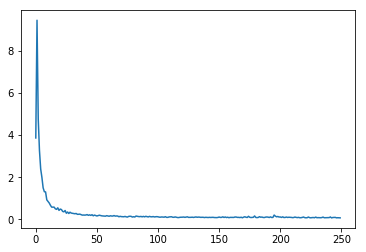

251

In [7]:
import pylab
pylab.figure()
pylab.plot(costs)
pylab.show()
step

In [8]:
# Evaluate training set from a saved checkpoint
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-200.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-200"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    errors = []
    for file_num in range(number_of_files):
        # load current training file
        fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
        data = cpio.loadmat(data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        intY = data['labels'][0]
        temp_n = len(intY)/batch_size
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
        d = {X: data1 ,Y: intY ,lng:[temp_n]*batch_size}
        pred = sess.run(eval_op,feed_dict = d)
        errors.append(np.abs(np.squeeze(pred[1]).reshape(-1)-intY.reshape(-1)) != 0)

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records/checkpoint-200


In [9]:
# Results on training set
[np.mean(err) for err in errors]

[0.048048922539312755,
 0.047241867043847245,
 0.056642873589684548,
 0.047563579887400502,
 0.063574778530484627,
 0.06662541254125412,
 0.073772083090662008,
 0.050495049504950498,
 0.073876618431073876,
 0.043316831683168314,
 0.060792079207920791]

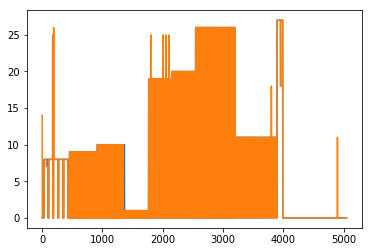

In [10]:
pylab.plot(intY.reshape(-1))
pylab.plot(np.squeeze(pred[1]).reshape(-1))
np.mean(np.abs(np.squeeze(pred[1]).reshape(-1)-intY.reshape(-1)) != 0)
pylab.show()